In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)


converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.0272972299461 occ= 2
MO #3 (A1 #3), energy= -0.426131190105552 occ= 2
MO #4 (E1x #1), energy= -0.289938520612844 occ= 2
MO #5 (E1y #1), energy= -0.289938520612846 occ= 2
MO #6 (A1 #4), energy= -0.034955913589639 occ= 0
MO #7 (A1 #5), energy= 0.664675049298746 occ= 0
MO #8 (E1x #2), energy= 1.1305709354121 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513673 occ= 0
MO #11 (A1 #7), energy= 1.57280313485609 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.29132770625067
Chemical Potential:  -0.16244721710124252
DFT trace:  7.124009715257124


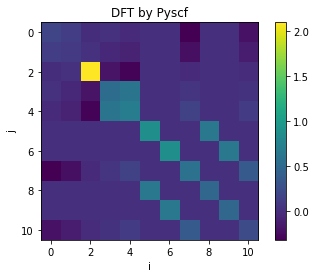

In [2]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
dft_mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
print('Chemical Potential: ', str(dft_mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
#mmwrite('dft_overlap.mtx', sparse.coo_matrix(ovlp))

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())

plt.imshow(dm.real)
plt.title("DFT by Pyscf")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

NTPoly Trace:  0.0


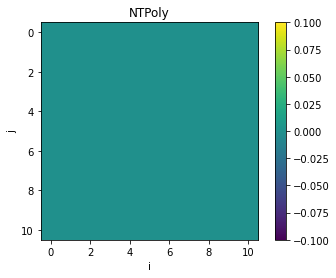

In [3]:
# NTPoly Solver
ntpoly_rho = nt.NTPoly_cp(h1e, ovlp, 10)
print("NTPoly Trace: ", ntpoly_rho.trace())

plt.imshow(ntpoly_rho.real)
plt.title("NTPoly")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

GCP steps:  17
Palser GCP trace:  (6+0j)
CP steps:  43
Palser CP trace:  (9.99999999999999+0j)


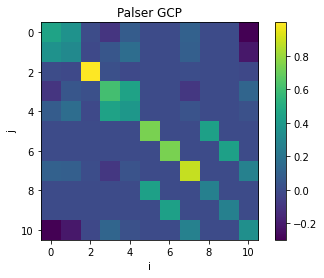

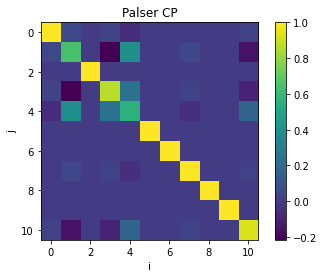

In [4]:
# Palser solver
mu = -5
palser_gcp_rho = pals.gcp(mu, h1e, 1000)
print("Palser GCP trace: ", palser_gcp_rho.trace())
palser_cp_rho = pals.cp(10, h1e, 1000)
print("Palser CP trace: ", palser_cp_rho.trace())

plt.figure(1)
plt.imshow(palser_gcp_rho.real)
plt.title("Palser GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(palser_cp_rho.real)
plt.title("Palser CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

DMM GCP trace:  6.0697190599881425
DMM CP trace:  6.069719059988061


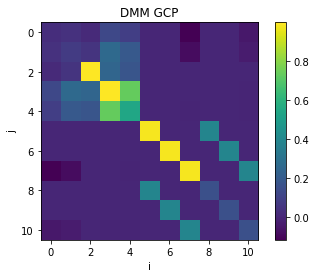

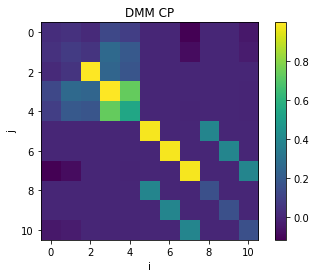

In [5]:
# DMM Solvers
dbeta = 0.003
num_electrons = 10
identity = np.identity(h1e.shape[0])
inv_ovlp = linalg.inv(ovlp)
init_rho = ovlp/2

dmm_gcp = gcp.rk4(gcp.rhs, init_rho, dbeta, h1e, inv_ovlp, identity, mu, 1000)
print("DMM GCP trace: ", dmm_gcp.trace())
dmm_cp = cp.rk4(cp.rhs, init_rho, dbeta, h1e, inv_ovlp, identity, 1000)
print("DMM CP trace: ", dmm_cp.trace())

plt.figure(1)
plt.imshow(dmm_gcp.real)
plt.title("DMM GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(dmm_cp.real)
plt.title("DMM CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

In [6]:
print(linalg.norm(dmm_cp @ inv_ovlp @ dmm_cp - dmm_cp))
print(linalg.norm(dmm_gcp @ inv_ovlp @ dmm_gcp - dmm_gcp))
print(linalg.norm(dm @ inv_ovlp @ dm - dm))
print(linalg.norm(dmm_gcp.conj().T - dmm_gcp))
print(cp.get_mu(dmm_gcp, h1e, inv_ovlp))

8.200810436516886e-16
9.613486261862642e-16
3.7382547180692014
5.141431427544781e-14
2.596519462450217


funm result may be inaccurate, approximate err = 1


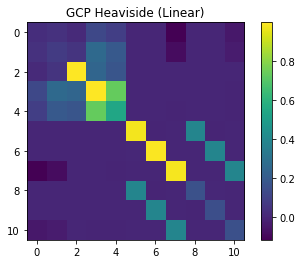

In [7]:
gcp_exact = ovlp @ linalg.funm(inv_ovlp @ h1e, lambda _: _ <= mu)
plt.imshow(gcp_exact.real)
plt.title("GCP Heaviside (Linear)")
plt.colorbar()

funm result may be inaccurate, approximate err = 1


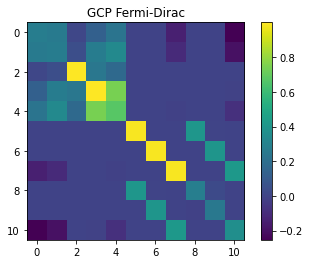

In [8]:
gcp_fermi = ovlp @ linalg.funm(inv_ovlp @ h1e, lambda _: 1/(1+np.exp(1000*dbeta*(_ - mu))))
plt.imshow(gcp_fermi)
plt.title("GCP Fermi-Dirac")
plt.colorbar()

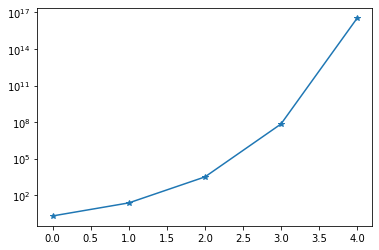

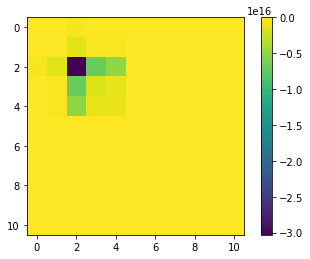

In [9]:
func_args = {'h':h1e, 'mu': mu, 'inv_ovlp': inv_ovlp}
rho = init_rho.copy()
norm_diff = []
for i in range(5):
    rho_next = gcp.steady_linear_single_step(rho, **func_args)
    norm_diff.append(linalg.norm(rho_next - rho))
    rho = rho_next
    if norm_diff[-1] < 1e-10:
        break

plt.figure(1)
plt.semilogy(norm_diff, '*-')

plt.figure(2)
plt.imshow(rho.real)
plt.colorbar()

In [10]:
linalg.norm(rho - rho @ rho)

1.078279154619445e+33

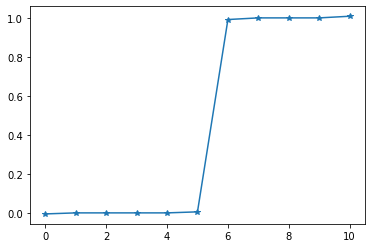

In [11]:
plt.plot(linalg.eigvalsh(gcp_exact, ovlp), '*-')

In [12]:
print(linalg.norm(h1e @ inv_ovlp - (h1e @ inv_ovlp).conj().T))
print(linalg.norm(init_rho @ inv_ovlp - inv_ovlp @ init_rho))
print(linalg.norm(dmm_gcp @ inv_ovlp - inv_ovlp @ dmm_gcp))

16.90517373976157
0.02530417921056407
1.9066859505145657


0.0


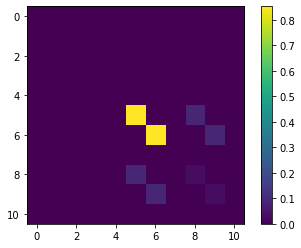

In [13]:
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.003
iden = np.identity(rho_i.shape[0])
mu = -5
B = inv_ovlp @ h1e
B += B.conj().T
B/= 2
print(linalg.norm(B - B.conj().T))
for i in range(1000):
    A = inv_ovlp @ rho_i
    A += A.conj().T
    A /= 2
    
    K = -dbeta/2 * (iden - A) @ (B - mu*iden)
    Kdag = -dbeta/2 * (B - mu*iden) @ (iden - A)
    
    rho_next = (iden + Kdag) @ rho_i @ (iden + K) - Kdag @ rho_i @ K
    herm_check.append(linalg.norm(rho_next - rho_next.conj().T))
    trace_check.append(rho_next.trace())
    rho_i = rho_next
    
plt.imshow(rho_i.real)
plt.colorbar()

In [14]:
herm_check[1:10]

[2.819555203814736e-16,
 4.324450217694487e-16,
 4.714637112128347e-16,
 5.372675789328841e-16,
 6.057178561709252e-16,
 6.360388116383689e-16,
 7.154578419817206e-16,
 8.416840894850874e-16,
 8.562398949295368e-16]

In [15]:
trace_check[1:10]

[5.5909132322184805,
 5.635579345370385,
 5.679514209460054,
 5.722558496450896,
 5.764570972942855,
 5.805430938967292,
 5.8450397635956834,
 5.883321510845529,
 5.920222710350787]

In [16]:
linalg.norm(rho_i @ inv_ovlp @ rho_i - rho_i)

0.04265053902075998

Text(0.5, 1.0, 'Norm Diff of Steady State')

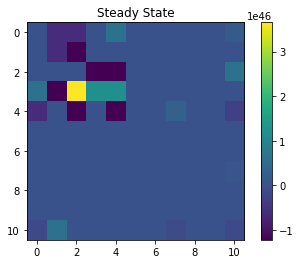

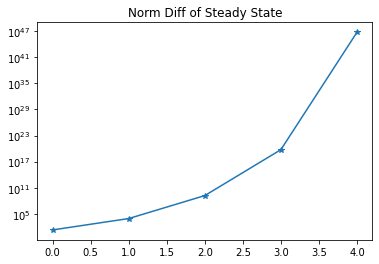

In [17]:
# Steady state
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.003
iden = np.identity(rho_i.shape[0])
inv_ovlp = ovlp.copy()
B = inv_ovlp @ h1e
B += B.conj().T
B/= 2

norm_diff = []
for i in range(5):
    A = inv_ovlp @ rho_i
    A += A.conj().T
    A /= 2
    rho_next = (iden + B) @ rho_i @ (iden + B) - B @ rho_i @ B
    rho_next += B @ A @ rho_i @ A @ B - (iden + B @ A) @ rho_i @ (iden + A @ B)
    rho_next += mu * ((iden + A) @ rho_i @ (iden + A) - A @ rho_i @ A)
    rho_next /= (3*mu)
    
    norm_diff.append(linalg.norm(rho_next - rho_i))
    if norm_diff[-1] < 1e-16:
        break
    
    rho_i = rho_next.copy()

plt.figure(1)
plt.imshow(rho_i.real)
plt.title("Steady State")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.title("Norm Diff of Steady State")